pytorch == 2.3.0+cu118

python == 3.11.9

cuda == 11.8


In [3]:
import torch
from transformers import BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [7]:
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

2.3.0+cu118
True


device(type='cuda')

In [8]:
def print_cuda_memory_info(device_id=0):
    device = torch.device(f'cuda:{device_id}')  # 確保裝置ID有效
    total_mem = torch.cuda.get_device_properties(device).total_memory
    reserved_mem = torch.cuda.memory_reserved(device)
    allocated_mem = torch.cuda.memory_allocated(device)
    free_mem = reserved_mem - allocated_mem  # 估算可用記憶體
    
    print(f"Device: {torch.cuda.get_device_name(device)}")
    print(f"Total Memory: {total_mem / 1e9:.2f} GB")
    print(f"Reserved Memory: {reserved_mem / 1e9:.2f} GB")
    print(f"Allocated Memory: {allocated_mem / 1e9:.2f} GB")
    print(f"Free Memory: {free_mem / 1e9:.2f} GB")

torch.cuda.empty_cache()
print_cuda_memory_info()

Device: NVIDIA GeForce GTX 1660 Ti
Total Memory: 6.44 GB
Reserved Memory: 0.47 GB
Allocated Memory: 0.41 GB
Free Memory: 0.06 GB


In [9]:
import pickle
def load_emcoded_data(directory):
    # 載入 encodings
    with open(f'{directory}/encodings.pickle', 'rb') as handle:
        encodings = pickle.load(handle)

    # 載入 labels
    with open(f'{directory}/labels.pickle', 'rb') as handle:
        labels = pickle.load(handle)

    return encodings, labels

### 創建資料模型

In [10]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = {key: torch.tensor(val) for key, val in encodings.items()}  # 提前轉換成 tensor
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}  # 直接索引已有 tensor
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [11]:
import matplotlib.pyplot as plt

def plot_metrics(epoch_statistics):
    epochs = range(1, len(epoch_statistics['train_losses']) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, epoch_statistics['train_losses'], 'b-', label='Training Loss')
    plt.plot(epochs, epoch_statistics['val_losses'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, epoch_statistics['train_accuracies'], 'b-', label='Training Accuracy')
    plt.plot(epochs, epoch_statistics['val_accuracies'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### train

In [7]:
from sklearn.model_selection import KFold
import torch.optim as optim
import torchmetrics
from datetime import datetime

def save_params(model, fold=None):
    current_date = datetime.now().strftime("%Y%m%d")
    file_name = ''
    if fold != None:
        file_name = f'parameters/{current_date}_fold_{fold}_model_parameters.pth'
    else:
        file_name = f'parameters/{current_date}_model_parameters.pth'

    torch.save(model.state_dict(), file_name)

def validate(model, val_loader, device):
    model.eval()
    val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=2).to(device)
    val_loss_metric = torchmetrics.MeanMetric().to(device)
    
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            val_loss_metric.update(loss)
            val_acc.update(outputs.logits, batch['labels'])

    avg_val_loss = val_loss_metric.compute().item()
    avg_val_accuracy = val_acc.compute().item() * 100
    return avg_val_loss, avg_val_accuracy

def train_and_validate(model, train_loader, val_loader, device, epochs=3, patience=2):
    optimizer = optim.AdamW(model.parameters(), lr=5e-5)
    train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=2).to(device)
    train_loss = torchmetrics.MeanMetric().to(device)

    min_val_loss = float('inf')
    no_improve_count = 0
    epoch_statistics = {'train_losses': [], 'val_losses': [], 'val_accuracies': [], 'train_accuracies': []}

    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss.update(loss)
            train_acc.update(outputs.logits, batch['labels'])

        epoch_statistics['train_losses'].append(train_loss.compute().item())
        epoch_statistics['train_accuracies'].append(train_acc.compute().item() * 100)
        train_acc.reset()
        train_loss.reset()

        val_loss, val_accuracy = validate(model, val_loader, device)
        epoch_statistics['val_losses'].append(val_loss)
        epoch_statistics['val_accuracies'].append(val_accuracy)

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            no_improve_count = 0
            epoch_statistics['best_val_loss'] = val_loss
            epoch_statistics['best_val_accuracy'] = val_accuracy
        else:
            no_improve_count += 1

        if no_improve_count >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    return epoch_statistics

def kfold_training(dataset, k=5, batch_size=16, device='cuda'):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_index, val_index) in enumerate(kf.split(dataset)):
        train_subsampler = SubsetRandomSampler(train_index)
        val_subsampler = SubsetRandomSampler(val_index)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)

        model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=2, ignore_mismatched_sizes=True).to(device)
        stats = train_and_validate(model, train_loader, val_loader, device)
        fold_results.append(stats)

        save_params(model, fold)

        print(f'Fold {fold + 1}: Best Val Loss: {stats["best_val_loss"]:.4f}, Best Val Accuracy: {stats["best_val_accuracy"]:.2f}%')
        plot_metrics(stats)

    # 計算和輸出平均結果
    avg_val_loss = sum([min(res['val_losses']) for res in fold_results]) / k
    avg_val_accuracy = sum([max(res['val_accuracies']) for res in fold_results]) / k
    print(f"Average Validation Loss: {avg_val_loss:.4f}")
    print(f"Average Validation Accuracy: {avg_val_accuracy:.2f}%")

In [8]:
# 載入訓練集
encodings, labels = load_emcoded_data('encoded_data/train')

# 創建數據集
train_dataset = TextDataset(encodings, labels)

### 使用k-fold

c:\Users\a9542\Desktop\programes\information_retrieval\final\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Early stopping at epoch 3
Fold 1: Best Val Loss: 0.2425, Best Val Accuracy: 90.68%


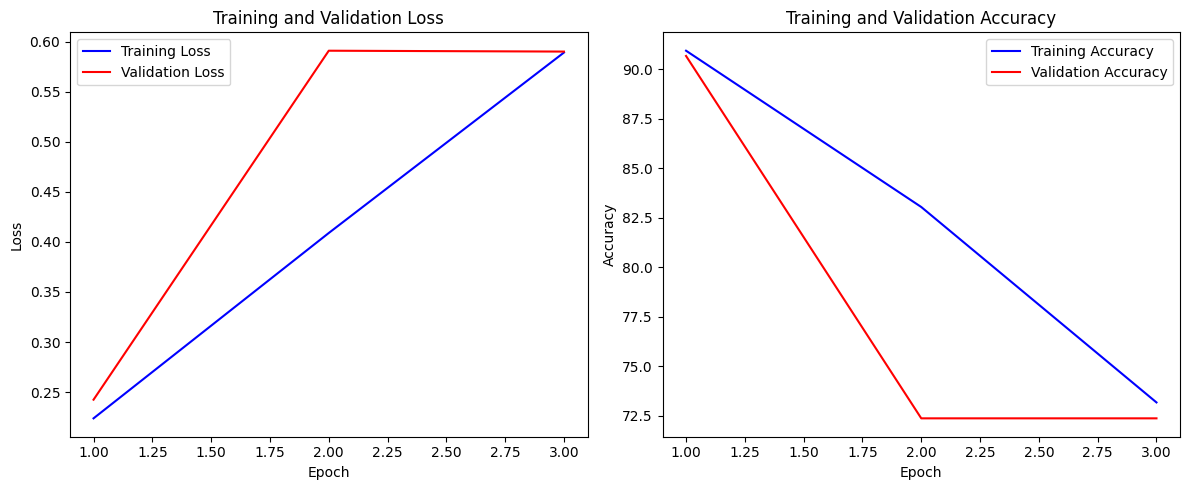

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 2: Best Val Loss: 0.1494, Best Val Accuracy: 94.28%


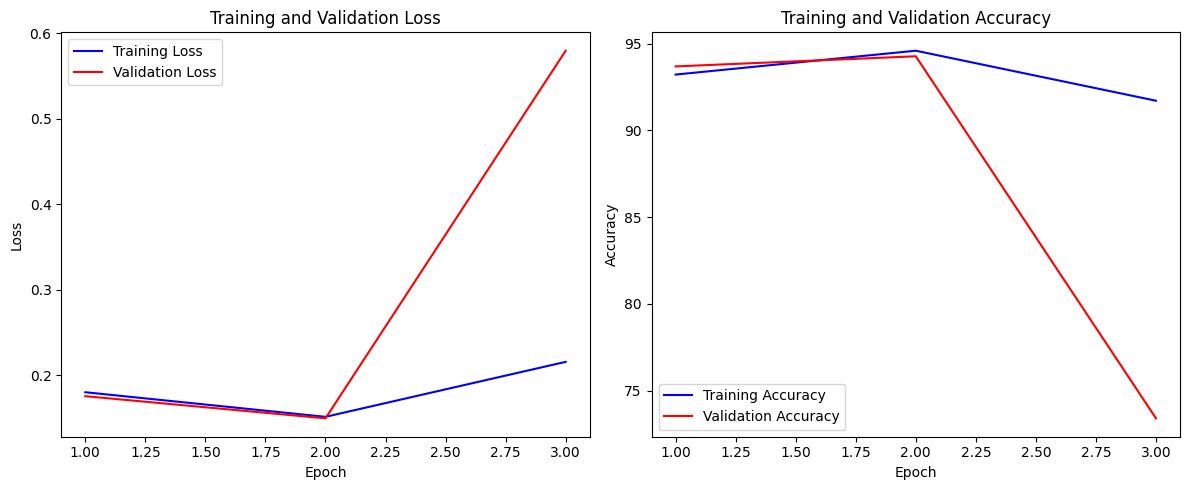

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 3: Best Val Loss: 0.1379, Best Val Accuracy: 94.70%


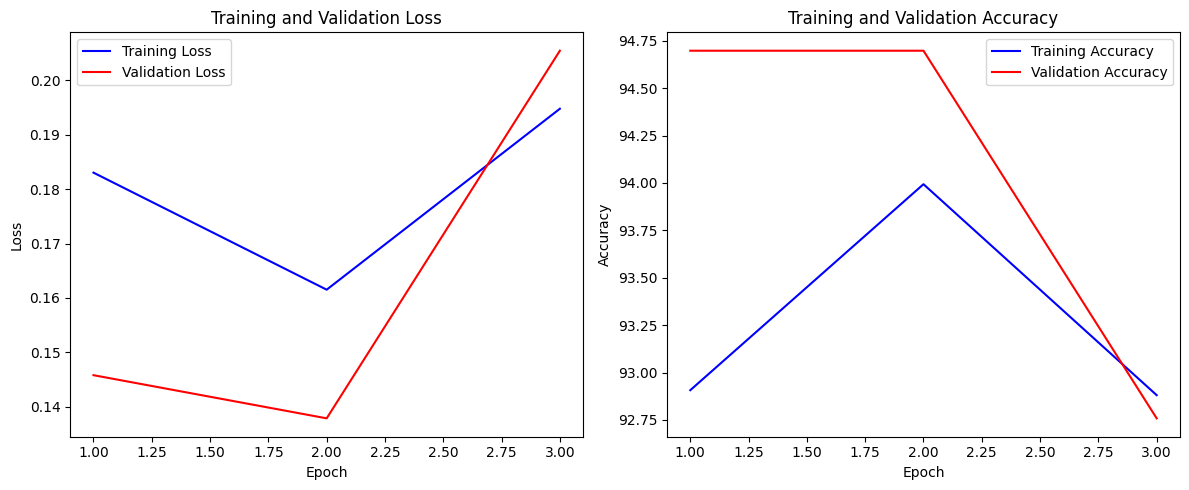

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 4: Best Val Loss: 0.1448, Best Val Accuracy: 94.40%


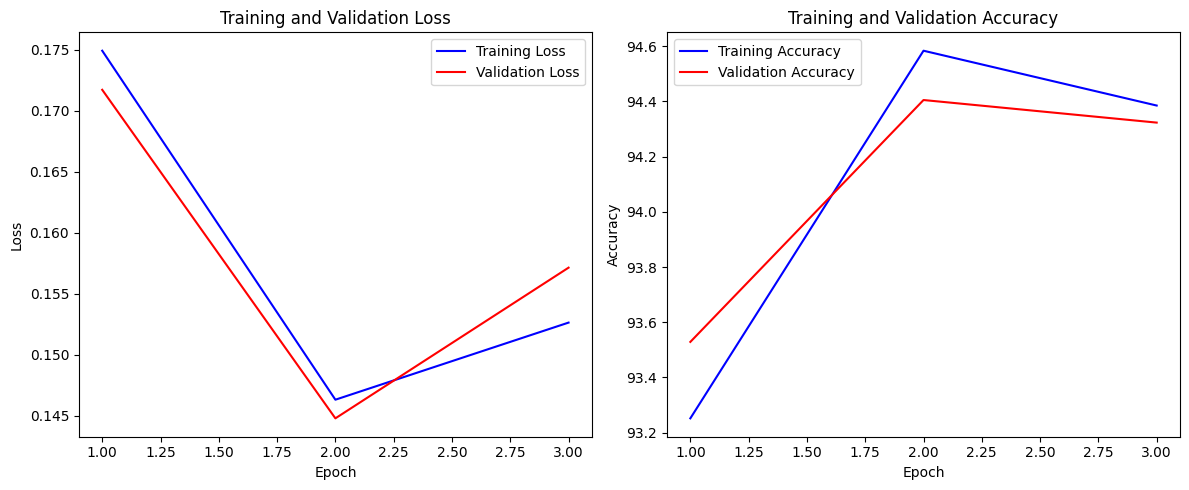

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

In [9]:
kfold_training(train_dataset, k=5, batch_size=16, device='cuda')

### 不使用k-fold

In [ ]:
# from sklearn.model_selection import train_test_split

# # 切分數據集
# train_data, val_data = train_test_split(train_dataset, labels, test_size=0.2, random_state=42)


# train_loader = DataLoader(train_data, batch_size=16)
# val_loader = DataLoader(val_data, batch_size=16)

# model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=2).to(device)

# # 訓練和驗證
# stats = train_and_validate(model, train_loader, val_loader, device)

# # 輸出結果
# print(f'Best Val Loss: {stats["best_val_loss"]:.4f}, Best Val Accuracy: {stats["best_val_accuracy"]:.2f}%')
# plot_metrics(stats)
